In [27]:
import chess
import chess.svg
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from IPython.display import display, Image ,clear_output
from stockfish import Stockfish
import tensorflow as tf

In [28]:
from copy import deepcopy

In [29]:
def fen_to_board(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == ' ':
                break
            elif c in '12345678':
                brow.extend( ['--'] * int(c) )
            elif c == 'p':
                brow.append( 'bp' )
            elif c == 'P':
                brow.append( 'wp' )
            elif c > 'Z':
                brow.append( 'b'+c.upper() )
            else:
                brow.append( 'w'+c )

        board.append( brow )
    return board

In [42]:
class Envi():
    def __init__(self,intial_fen):
        self.stockfish=Stockfish("C:/Users/DELL/Downloads/stockfish/stockfish-windows-x86-64-avx2.exe",parameters={"Hash":2048})
        self.stockfish.set_skill_level(4)
        if intial_fen == "":
            self.board = chess.Board()
        else:
            self.board = chess.Board(intial_fen)
            self.stockfish.set_fen_position(intial_fen)
        fen=self.board.fen()
        text=fen_to_board(fen)
        self.tokenizer=Tokenizer()
        self.tokenizer.fit_on_texts(text)

    def step(self,action):
        r=50
        self.stockfish.set_fen_position(self.board.fen())
        self.board.push(action)
        if str(self.stockfish.will_move_be_a_capture(action.uci()).name)!="NO_CAPTURE":
            r=500
        self.stockfish.set_fen_position(self.board.fen())
        action=self.act_to_encod(action)
        self.boardprev=deepcopy(self.board)
        stockfish_move = self.stockfish.get_best_move()
        stockfish_move=chess.Move.from_uci(stockfish_move)
        if str(self.stockfish.will_move_be_a_capture(stockfish_move.uci()).name)!="NO_CAPTURE":
            r=r-550
        self.board.push(stockfish_move)
        self.brd=self.state()
        # if self.boardprev.is_checkmate():
        #     return 10000,self.brd,1,action
        # elif self.boardprev.is_stalemate():
        #     return 10,self.brd,1,action
        # elif self.boardprev.is_insufficient_material():
        #     return 10,self.brd,1,action
        # elif self.boardprev.can_claim_draw():
        #     return 10,self.brd,1,action
        # elif self.boardprev.is_check():
        #     return 5000,self.brd,0,action
        # elif self.board.is_checkmate():
        #     return -500,self.brd,1,action
        # elif self.board.is_check():
        #     return -200,self.brd,0,action
        # else:
        #     return r,self.brd,0,action
        if self.boardprev.is_checkmate():
            return 10000,self.brd,1,action
        elif self.boardprev.is_stalemate():
            return 10,self.brd,1,action
        elif self.boardprev.is_insufficient_material():
            return 10,self.brd,1,action
        elif self.boardprev.can_claim_draw():
            return 100,self.brd,1,action
        elif self.boardprev.is_check():
            return 3000,self.brd,0,action
        elif self.board.is_checkmate():
            return -10000,self.brd,1,action
        elif self.board.is_check():
            return -3000,self.brd,0,action
        else:
            return r,self.brd,0,action
        
    def stepc(self,action):
        self.board.push(action)
        action=self.act_to_encod(action)
        self.brd=self.state()
        if self.board.is_checkmate():
            return 1000,self.brd,1,action
        if self.board.can_claim_threefold_repetition():
            return -20,self.brd,0,action
        elif self.board.is_stalemate():
            return 10,self.brd,1,action
        elif self.board.is_insufficient_material():
            return 10,self.brd,1,action
        elif self.board.can_claim_draw():
            return 10,self.brd,1,action
        elif self.board.is_check():
            return 10,self.brd,0,action
        else:
            return 0,self.brd,0,action
    
    def act_to_encod(self,action):
        # move=chess.Move.from_uci(action)
        move=action
        return [move.from_square,move.to_square]
    
    def state(self):
        fen=self.board.fen()
        text=fen_to_board(fen)
        seq=self.tokenizer.texts_to_sequences(text)
        self.brd=np.array(seq).reshape(64)
        return self.brd
        
    def legal(self):
        self.pmoves=[x for x in self.board.legal_moves]
        return self.pmoves
    
    def evaluate(self,q_network):
        q=[]
        action=[]
        for i in self.legal():
            self.board.push(i)
            st=np.expand_dims(self.state(),axis=0)
            st=tf.convert_to_tensor(st,dtype=tf.float32)
            q.append(q_network(st))
            action.append(i)
            self.board.pop()
        return q,action

    def reset(self):
        self.board.reset()
        return self.board.fen()

In [6]:
import tensorflow as tf
import numpy as np
import time
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple

In [7]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.99            # discount factor
ALPHA = 3e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
TAU = 1e-3                # soft update of target parameters

In [1]:
from tensorflow.keras.models import load_model
q_network=load_model('aroyant.h5')

In [15]:
# q_network = Sequential([
#     Input(shape=(66,)),
#     tf.keras.layers.Reshape((11,6)),
#     tf.keras.layers.Conv1D(filters=16, kernel_size=8, activation='relu'),
#     tf.keras.layers.Flatten(),                      
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),            
#     Dense(units=32, activation='relu'),            
#     Dense(units=1, activation='linear'),
#     ])

# q_network=model

target_q_network = Sequential([
    Input(shape=(64,)),
    tf.keras.layers.Reshape((8,8)),
    tf.keras.layers.Conv1D(filters=16, kernel_size=8, activation='relu'),
    tf.keras.layers.Flatten(),                      
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),            
    Dense(units=32, activation='relu'),            
    Dense(units=1, activation='linear'),
    ])

# q_network = Sequential([
#     Input(shape=(66,)),
#     tf.keras.layers.Reshape((11,6)),
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),                      
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),            
#     Dense(units=32, activation='relu'),            
#     Dense(units=1, activation='linear'),
#     ])

# q_network=model

# target_q_network = Sequential([
#     Input(shape=(66,)),
#     tf.keras.layers.Reshape((11,6)),
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),                      
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),            
#     Dense(units=32, activation='relu'),            
#     Dense(units=1, activation='linear'),
#     ])


optimizer =Adam(learning_rate=ALPHA)

In [16]:
q_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 8, 8)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 16)             1040      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [17]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [18]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    states,rewards, next_states, done_vals,actions = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets =rewards + (gamma * max_qsa * (1 - done_vals))
    q_values = q_network(states)
    # q_values = tf.gather_nd(q_values,tf.concat((next_states,actions),axis=1))    
    loss = MSE(y_targets, q_values)
    
    return loss

In [19]:
@tf.function
def agent_learn(experiences, gamma):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [20]:
num_games=10000
num_moves=200

total_point_history = []
total_step_history = []

num_p_av=30
epsilon=0
mini_batch_size=32

target_update_interval=10

target_q_network.set_weights(q_network.get_weights())

In [28]:
def getaction(env,epsilon):
    # if np.random.rand() < epsilon and len(env.legal()) > 0:
    #     return env.legal()[np.random.randint(len(env.legal()))]
    # else:
        q = []
        for i in env.legal():
            da1,new_state,da2,action=env.stepc(i)
            # state_qn = np.concatenate((env.state(),action),axis=None)
            state_qn=np.expand_dims(env.state(),axis=0)
            env.board.pop()
            q.append(q_network(state_qn))
        if q == []:
            return None
        else:
            return env.legal()[np.argmax(q)]
    

In [29]:
def qupdate(t):
    if t % target_update_interval == 0:
        return True
    else:
        return False
        

In [30]:
def get_experiences(mem):
    min=mini_batch_size
    try:
        batch=random.sample(mem,min)
    except:
        min=5
        batch=random.sample(mem,min)
    states=np.zeros((min,64))
    rewards=np.zeros(min)
    next_states=np.zeros((min,64)) 
    done_vals=np.zeros(min)
    action=np.zeros((min,2))
    for i in range(min):
        # print('\n')
        # print(i)
        # print('\n')
        # print(batch[i])
        states[i]=batch[i][0]
        rewards[i]=batch[i][1]
        next_states[i]=batch[i][2]
        done_vals[i]=batch[i][3]
        action[i]=batch[i][4]
    cbatch=(tf.convert_to_tensor(states,dtype=tf.float32),
            tf.convert_to_tensor(rewards,dtype=tf.float32),
            tf.convert_to_tensor(next_states,dtype=tf.float32),
            tf.convert_to_tensor(done_vals,dtype=tf.float32),
            tf.convert_to_tensor(action,dtype=tf.float32))
    return cbatch

In [31]:
def get_new_eps(eps):
    eps=eps*0.99
    # if eps < 0.3:
    #     return 0.3
    return eps

In [32]:
import matplotlib.pyplot as plt

[-14700, -14150, -19300]

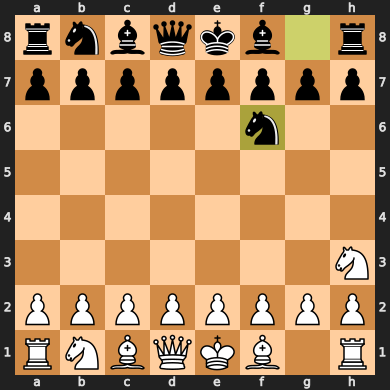

Episode 2 | Step 2 | last move point 50

KeyboardInterrupt: 

In [33]:
memory_buffer=deque(maxlen=MEMORY_SIZE)
for i in range(num_games):
    boardpos=[]
    env=Envi("")
    total_points=0
    reward=0

    for t in range(1,num_moves):
        state=env.state()
        print(f"\rEpisode {i+1} | Step {t} | last move point {reward}", end="")
        action=getaction(env,epsilon)
        if action==None:
            break
        reward,next_state,done,action=env.step(action)
        # memory_buffer.append((state,action,reward,next_state,done))
        memory_buffer.append([state,reward,next_state,done,action])

        update=qupdate(t)

        if update:
            experiences=get_experiences(memory_buffer)

            agent_learn(experiences,GAMMA)

        clear_output()
        display(total_point_history[-10:])
        display(env.board)
        
        state=next_state
        total_points+=reward

        boardpos.append(env.board.peek())

        if done:
            env.board.outcome()
            total_step_history.append(t)
            break
    
    total_point_history.append(total_points)
    av_latest_points=np.mean(total_point_history[-20:])
    env.board.outcome()

    epsilon=get_new_eps(epsilon)

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        q_network.save('panchoyant.h5')

    if av_latest_points >=10000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('panchoyant.h5')
        break

In [ ]:
import utils

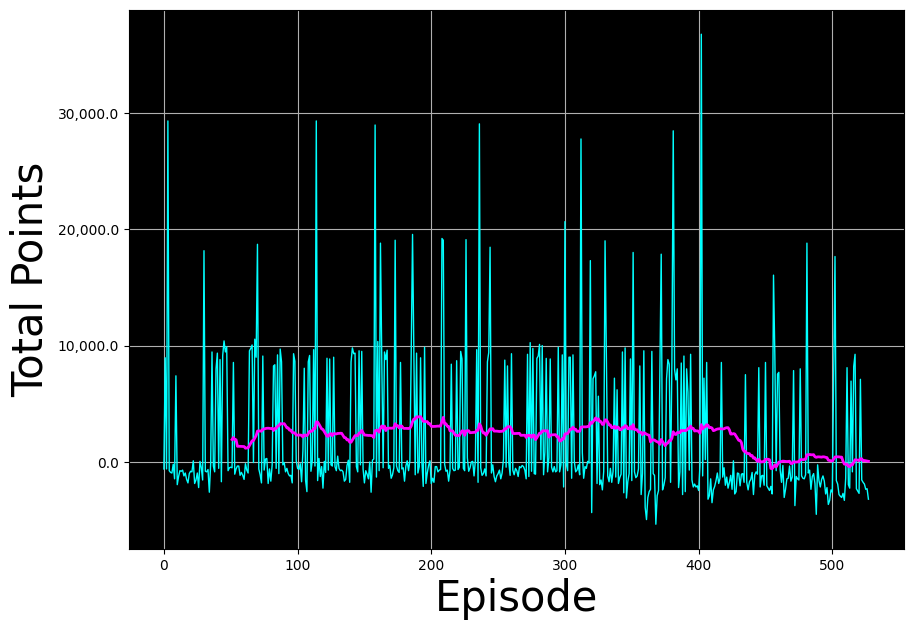

In [ ]:
utils.plot_history(total_point_history)

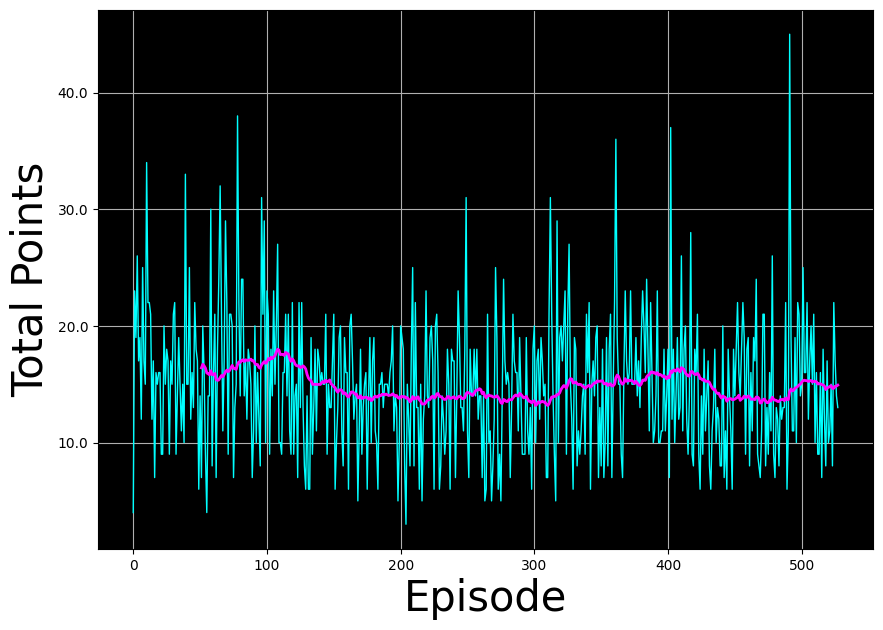

In [ ]:
utils.plot_history(total_step_history)

In [ ]:
q_network.save('panchoyant.h5')

In [ ]:
import pickle
with open('tokenizer_data.pkl','wb') as f:
    pickle.dump({'tokenizer':env.tokenizer},f)